# Sparse regression between model parameters and metagenomic profile

We apply sparse regression using lasso in order to determine if there is a correlation between the model parameters inferred from enzyme dynamics, and the metagenomic profile of a soil sample.

In [1]:
import os, sys
import time
import csv
import tqdm.notebook as tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.optimize import curve_fit
from sklearn import linear_model
from sklearn.decomposition import PCA
import warnings
from sklearn.exceptions import ConvergenceWarning

from mgsa.io import samples_from_soils, get_function, get_data
from mgsa.modeling import Model

In [2]:
NARG_INFO = {
    "KO": "K00370",
    "ORF_GROUPS_FPATH": "../out/groups/assignments_K00370_v1.tsv"
}

NIRB_INFO = {
    "KO": "K00362",
    "ORF_GROUPS_FPATH": "../out/groups/assignments_K00362_v1.tsv"
}

NATIVE_IDXS = [2, 4, 5, 8, 10, 11, 13, 14, 15, 16]
NATIVE_PHS = np.array([5.0, 5.3, 5.41, 5.8, 6.15, 6.3, 6.5, 6.75, 6.9,  7.1])
PERTURBED_PHS = np.linspace(3.8, 8.4, 11)

OUTDIR = "../out/model_regression/model1"
IMGDIR = f"{OUTDIR}/images"
os.makedirs(OUTDIR, exist_ok=True)
os.makedirs(IMGDIR, exist_ok=True)

def texify(param_name):
    return {
        "gamma_A": "\\gamma_{{A}}", 
        "gamma_I": "\\gamma_{{I}}", 
        "r_A": "r_{{A}}", 
        "r_I1": "r_{{I1}}", 
        "r_I2": "r_{{I2}}", 
        "K_A": "K_{{A}}", 
        "K_I": "K_{{I}}", 
        "mu": "\\mu", 
    }[param_name]

Load the data.

In [3]:
# Final 3 points will be for fitting the enzyme
t_data = np.linspace(0, 22, 23)

# For the drug data, we only want to fit the Nitrate and Nitrite curves
t_data_drug = np.linspace(0, 19, 20)

soils = [
    'Soil3', 'Soil5', 'Soil6', 'Soil9', 'Soil11', 
    'Soil12', 'Soil14', 'Soil15', 'Soil16', 'Soil17'
]

nar_t0 = pd.read_csv(
    '../out/KO_abundances/T0data_K00370.tsv', sep='\t', header=None,
).values
nar_t9_none = pd.read_csv(
    '../out/KO_abundances/T9data_K00370_None.tsv', sep='\t', header=None,
).values
nar_t9_chl = pd.read_csv(
    '../out/KO_abundances/T9data_K00370_CHL.tsv', sep='\t', header=None,
).values

nir_t0 = pd.read_csv(
    '../out/KO_abundances/T0data_K00362.tsv', sep='\t', header=None,
).values
nir_t9_none = pd.read_csv(
    '../out/KO_abundances/T9data_K00362_None.tsv', sep='\t', header=None,
).values
nir_t9_chl = pd.read_csv(
    '../out/KO_abundances/T9data_K00362_CHL.tsv', sep='\t', header=None,
).values

nit_t0 = pd.read_csv(
    '../out/KO_abundances/T0data_K17877.tsv', sep='\t', header=None,
).values
nit_t9_none = pd.read_csv(
    '../out/KO_abundances/T9data_K17877_None.tsv', sep='\t', header=None,
).values
nit_t9_chl = pd.read_csv(
    '../out/KO_abundances/T9data_K17877_CHL.tsv', sep='\t', header=None,
).values

Define models for the CHL+ and CHL- cases.

In [4]:
##############################################################################
### Define the ODE and Model(s)

def RHS(y, params):
    x1, x2, x3, A, I = y
    gamma_A = params['gamma_A']
    gamma_I = params['gamma_I']
    r_A = params['r_A']
    r_I1 = params['r_I1']
    r_I2 = params['r_I2']
    K_A = params['K_A']
    K_I = params['K_I']
    mu = params['mu']

    A = max(A, 1e-10)
    I = max(I, 1e-10)
    alpha = gamma_A*r_A*A/(K_A + A)*x1 + gamma_I*I/(K_I + I)*(r_I1*x2 + r_I2*x3)
    xi_1_temp = gamma_A*r_A*A
    xi_2_temp = gamma_I*r_I1*I
    xi_3_temp = gamma_I*r_I2*I
    xi_1 = xi_1_temp / (xi_1_temp + xi_2_temp + xi_3_temp + 1e-5)
    xi_2 = xi_2_temp / (xi_1_temp + xi_2_temp + xi_3_temp + 1e-5)
    xi_3 = xi_3_temp / (xi_1_temp + xi_2_temp + xi_3_temp + 1e-5)
    dx1 = xi_1*alpha - mu*x1
    dx2 = xi_2*alpha - mu*x2
    dx3 = xi_3*alpha/2 - mu*x3
    dA = -r_A*x1*A/(K_A + A)
    dI = r_A*x1*A/(K_A + A) - (I/(K_I + I))*(r_I1*x2 + r_I2*x3)

    dydt = np.array([dx1, dx2, dx3, dA, dI])
    return dydt


##############################################################################
### Ordered parameters: [gamma_A, gamma_I, r_A, r_I1, r_I2, K_A, K_I, mu]

PARAM_NAMES = ["gamma_A", "gamma_I", "r_A", "r_I1", "r_I2", "K_A", "K_I", "mu"]

# Fixed parameters
K_A = 0.1
K_I = 0.1
mu_chl_pos = 0.0
mu_chl_neg = 0.2

FIXED_PARAMS_CHL_POS = {
    "K_A": K_A, 
    "K_I": K_I, 
    "mu": mu_chl_pos,
    "gamma_A": 0.,
    "gamma_I": 0.,
    "r_I2": 0.,
}
FIXED_PARAMS_CHL_NEG = {
    "K_A": K_A, 
    "K_I": K_I, 
    "mu": mu_chl_neg,
}


##############################################################################
### Construct the CHL+ and CHL- models

MODEL_CHL_POS = Model(
    RHS, param_names=PARAM_NAMES, 
    fixed_params=FIXED_PARAMS_CHL_POS,
)

MODEL_CHL_NEG = Model(
    RHS, param_names=PARAM_NAMES, 
    fixed_params=FIXED_PARAMS_CHL_NEG,
)

print("CHL+ Model:\n", MODEL_CHL_POS)
print("CHL- Model:\n", MODEL_CHL_NEG)


CHL+ Model:
 Model [num_params=8, num_inferred=2]
	Fixed params: {'K_A': 0.1, 'K_I': 0.1, 'mu': 0.0, 'gamma_A': 0.0, 'gamma_I': 0.0, 'r_I2': 0.0}
CHL- Model:
 Model [num_params=8, num_inferred=5]
	Fixed params: {'K_A': 0.1, 'K_I': 0.1, 'mu': 0.2}


Fit the model.

native:   0%|          | 0/10 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

perturbed:   0%|          | 0/11 [00:00<?, ?it/s]

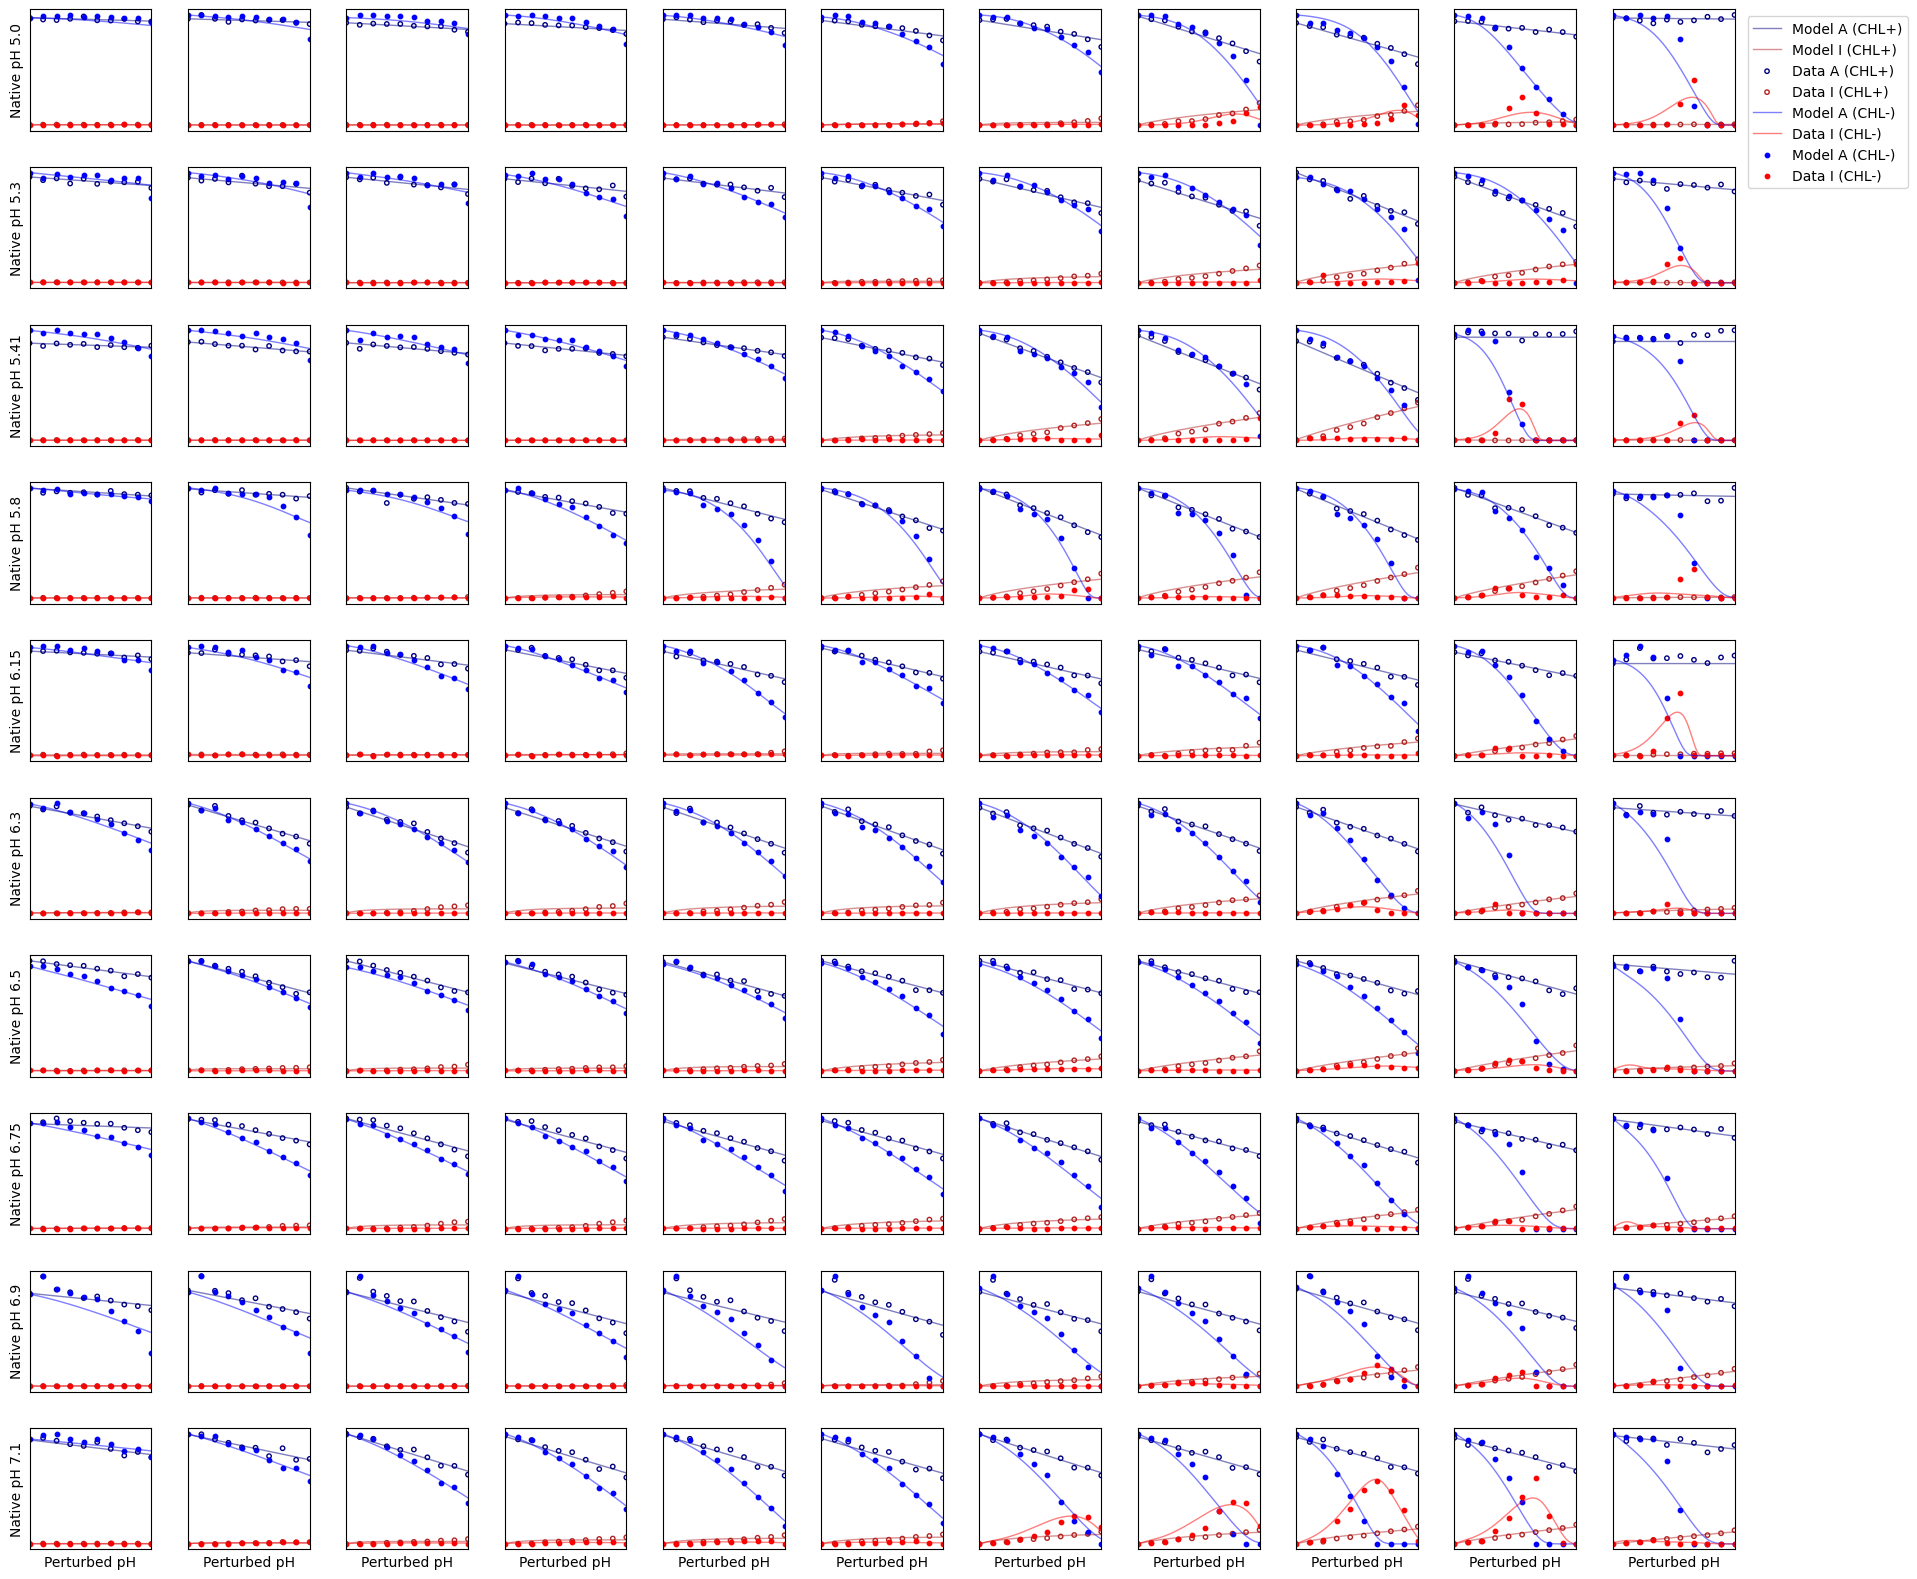

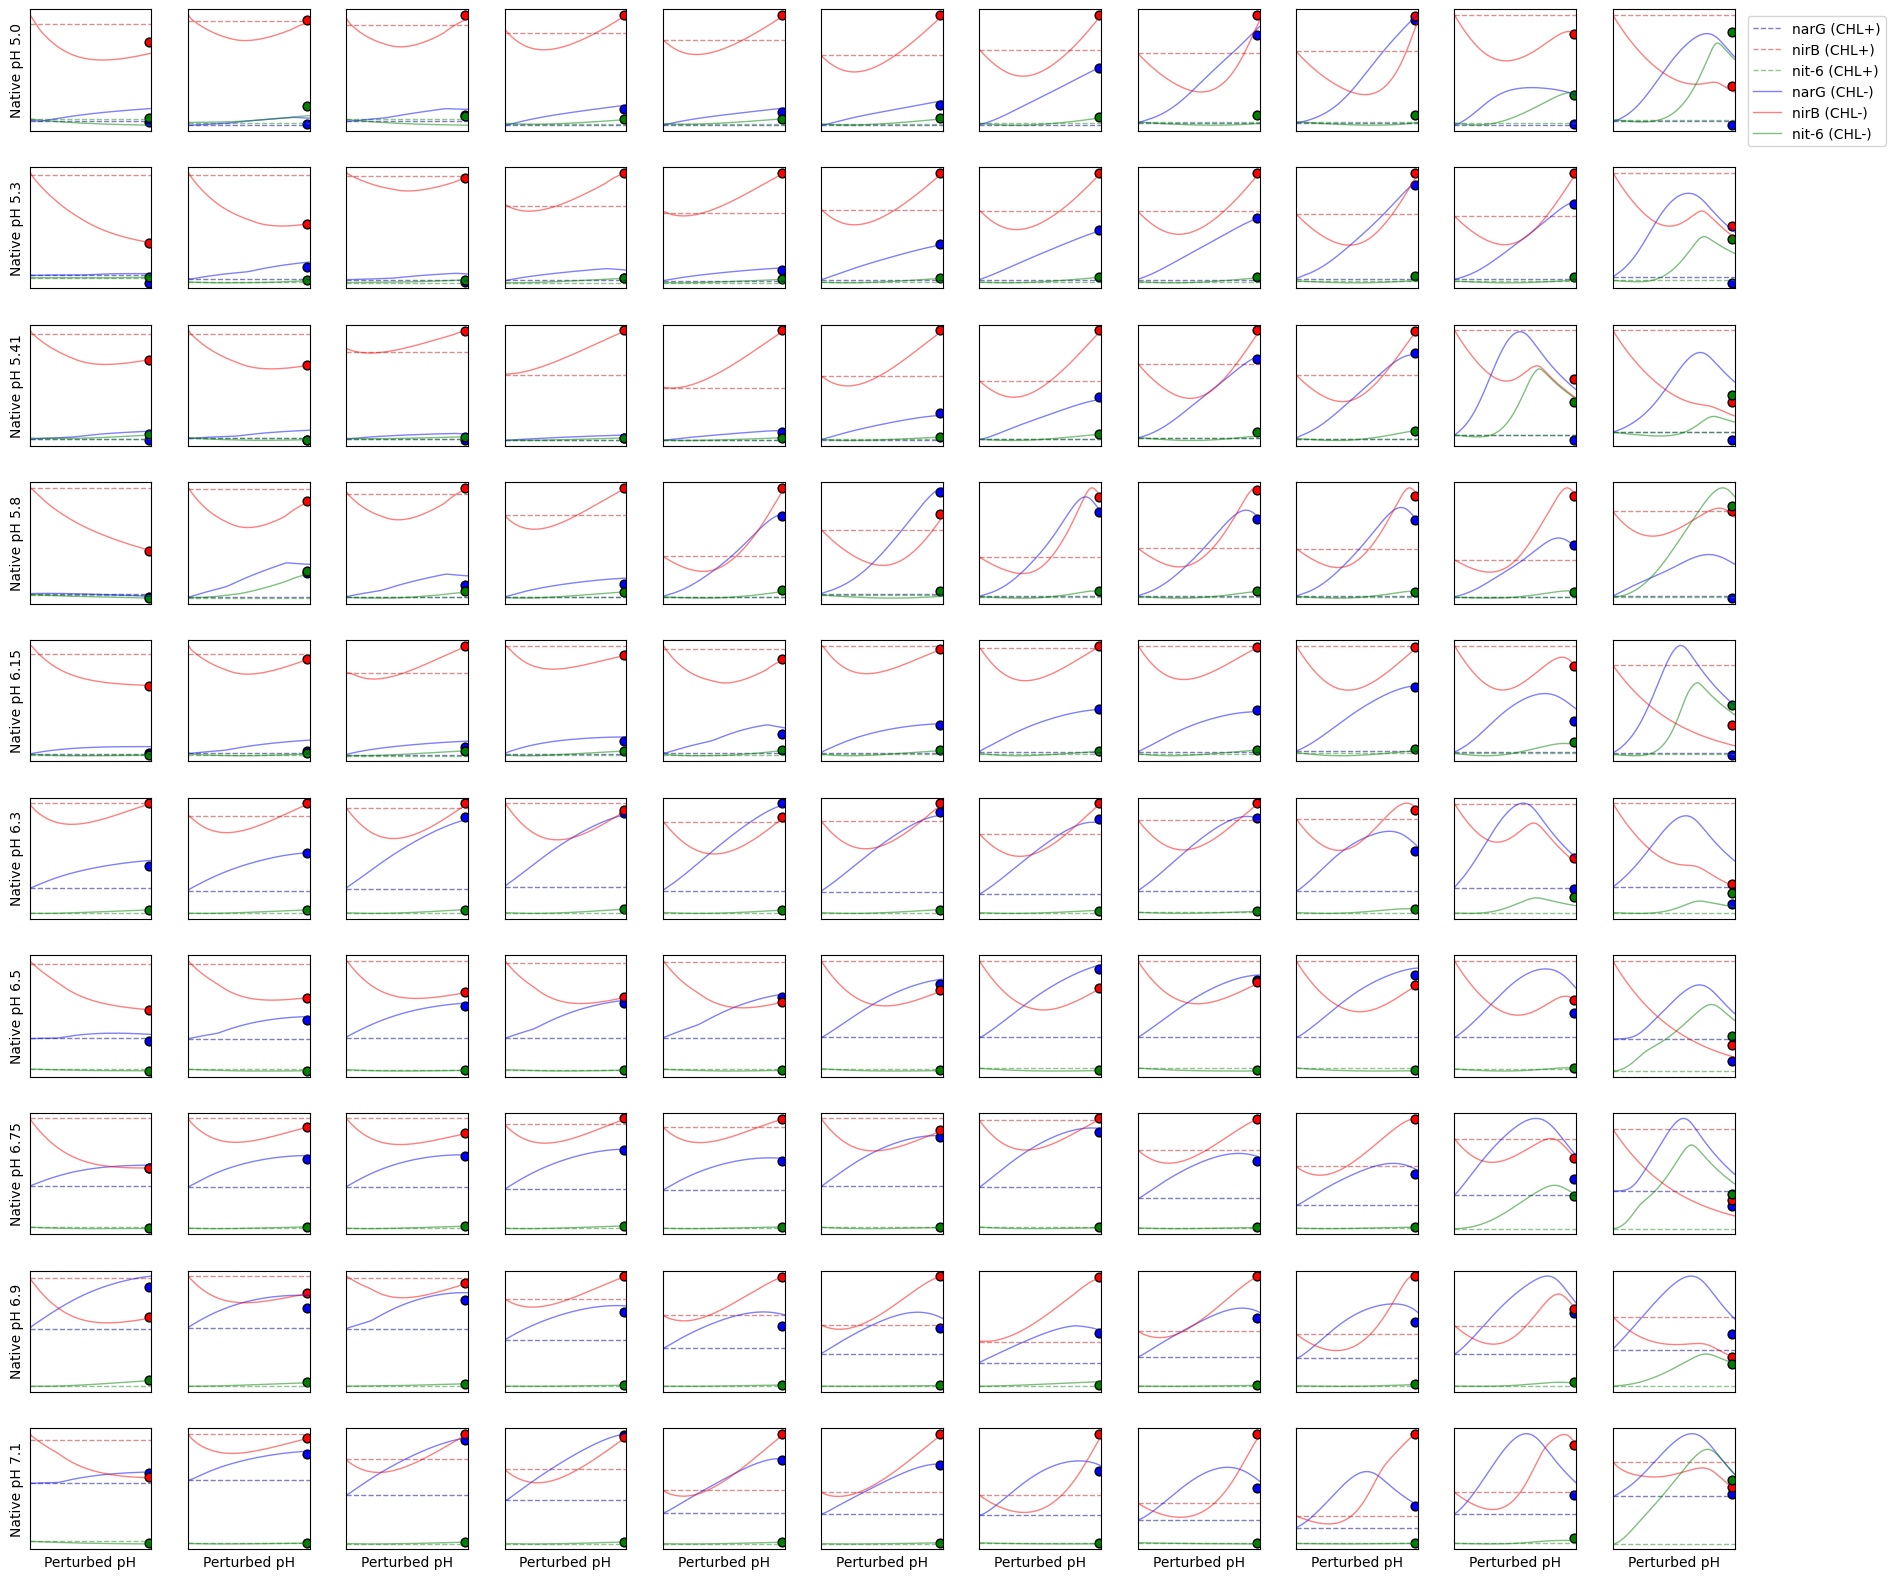

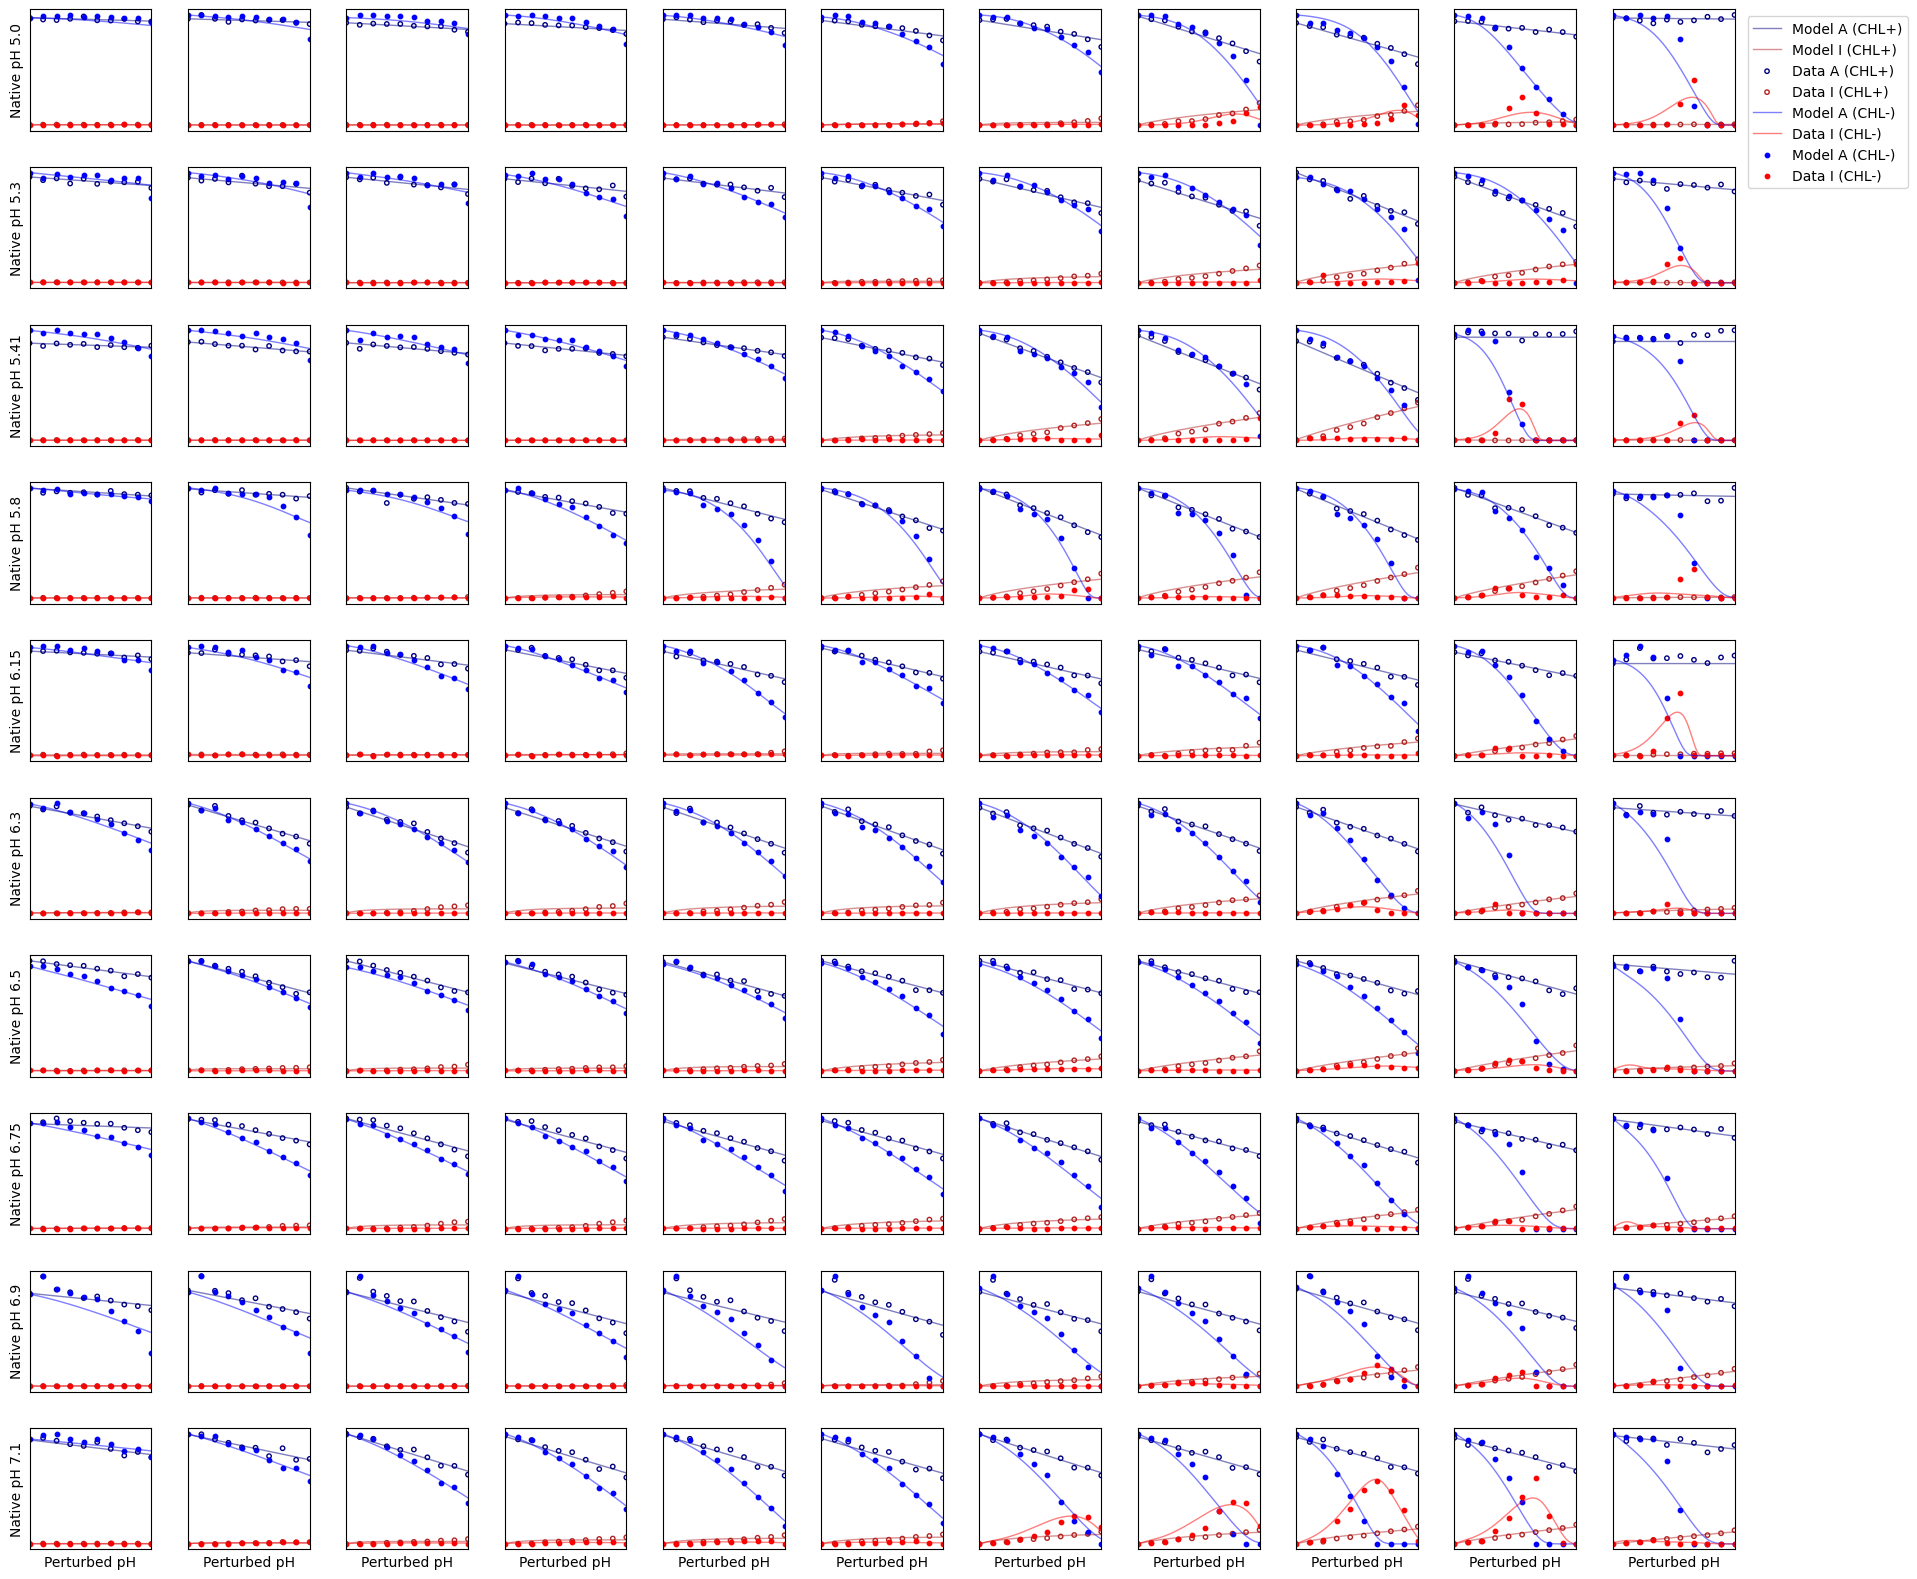

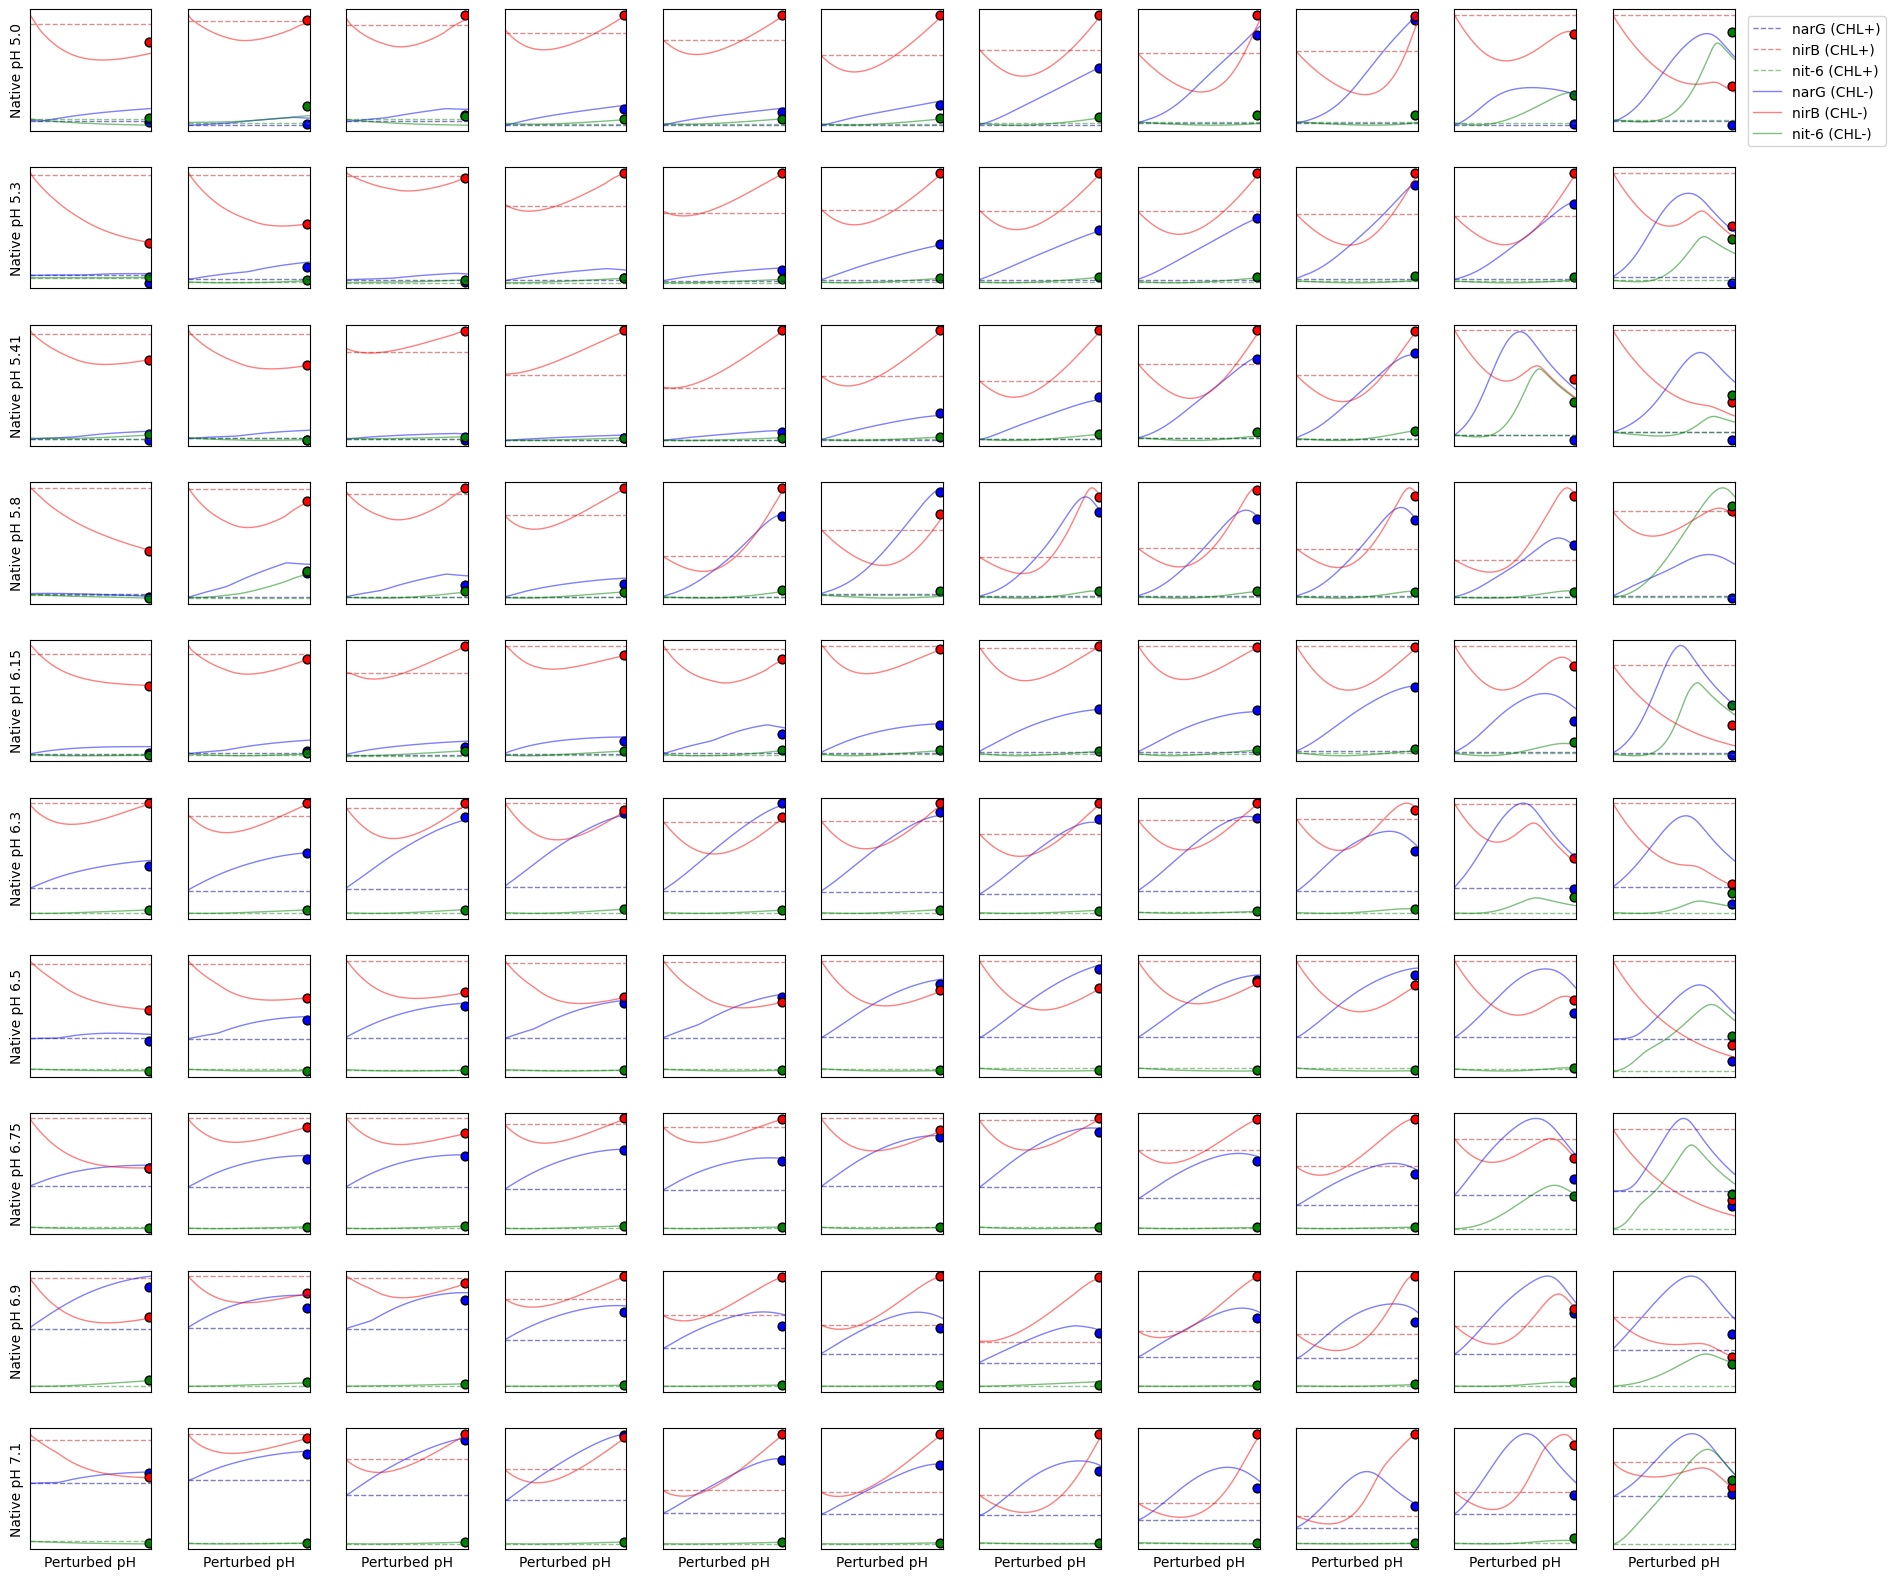

In [5]:
DO_PLOT = True

if DO_PLOT:
    fig, axs = plt.subplots(10, 11, figsize=(22, 20))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    fig_x, axs_x = plt.subplots(10, 11, figsize=(22, 20))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)


# Specify a weighting where the biomass points 'matter more' when computing the 
# curve fit. We want to force it to pick parameters so that these enzyme curves 
# do what is expected of them.
sigma = np.ones(23)
sigma[-1] = 1
sigma[-2] = 1
sigma[-3] = 1

# Timestepping
dt = 0.05
T = 9
N = int(T/dt)

indices = np.linspace(0, int(9/dt-1), 10).astype(int)
inferred_params_chl_pos = np.nan * np.ones([10, 11, 2])
inferred_params_chl_neg = np.nan * np.ones([10, 11, 5])
plot_t = np.linspace(0, 9, N)
plot_t_scatter = np.linspace(0, 9, 10)
for native in tqdm.trange(10, desc="native"):
    for pert in tqdm.trange(11, desc="perturbed", leave=False):
        
        # Scaled initial and final enzyme levels
        scale = nir_t0[9 - native, pert]
        x1_0 = nar_t0[9 - native, pert]/scale
        x2_0 = 1
        x3_0 = nit_t0[9 - native, pert]/scale
        x1_f = nar_t9_none[9 - native, pert]/scale
        x2_f = nir_t9_none[9 - native, pert]/scale
        x3_f = nit_t9_none[9 - native, pert]/scale
        
        # Collect soil samples for the native/perturbed sample
        sample = samples_from_soils(soils[9 - native])[pert]        
        
        # Load functional data for the CHL+ case
        function = get_function(sample, drug='CHL')
        A_data_drug = np.mean(function[0:3,:], axis=0)
        I_data_drug = np.mean(function[3:,:], axis=0)
        y_data_drug = np.concatenate([A_data_drug, I_data_drug])
        
        # Load functional data for the CHL- case, appending final enzyme levels
        function = get_function(sample)
        A_data = np.mean(function[0:3,:], axis=0)
        I_data = np.mean(function[3:,:], axis=0)
        y_data = np.concatenate([A_data, I_data, [x1_f, x2_f, x3_f]])
        
        # Fit and plot CHL+ model
        A_0 = A_data_drug[0]
        I_0 = I_data_drug[0]
        y0 = np.array([x1_0, x2_0, x3_0, A_0, I_0])
        def model_drug(t, r_A, r_I):
            params = {"r_A": r_A, "r_I1": r_I}
            _, _, _, A, I = MODEL_CHL_POS.simulate(y0, params, dt, T)
            A_out = A[indices]
            I_out = I[indices]
            return np.concatenate([A_out, I_out])
        
        initial_guess = [0.1, 0.1]
        bounds = (
            [0.001, 0.001], 
            [10, 10],
        )
        popt, pcov = curve_fit(
            model_drug, t_data_drug, y_data_drug, 
            p0=initial_guess, 
            bounds=bounds,
            maxfev=100000,
        )
        inferred_params_chl_pos[native, pert, :] = popt

        if DO_PLOT:
            # Plot the inferred model (CHL+)
            params = {"r_A": popt[0], "r_I1": popt[1]}
            x1, x2, x3, A, I = MODEL_CHL_POS.simulate(y0, params, dt, T)
        
            ax = axs[native, pert]
            ax.plot(
                plot_t, A, 
                color='navy', alpha=0.5, linewidth=1, 
                label="Model A (CHL+)"
            )
            ax.plot(
                plot_t, I, 
                color='firebrick', alpha=0.5, linewidth=1,
                label="Model I (CHL+)"
            )
            ax.scatter(
                plot_t_scatter, A_data_drug, 
                color='navy', s=10, facecolors='none',
                label="Data A (CHL+)"
            )
            ax.scatter(
                plot_t_scatter, I_data_drug, 
                color='firebrick', s=10, facecolors='none',
                label="Data I (CHL+)"
            )
        
            ax = axs_x[native, pert]
            ax.plot(
                plot_t, x1, 
                color='navy', alpha=0.5, linewidth=1, linestyle='--',
                label="narG (CHL+)"
            )
            ax.plot(
                plot_t, x2, 
                color='firebrick', alpha=0.5, linewidth=1, linestyle='--',
                label="nirB (CHL+)"
            )
            ax.plot(
                plot_t, x3, 
                color='forestgreen', alpha=0.5, linewidth=1, linestyle='--',
                label="nit-6 (CHL+)"
            )
        
        # Fit and plot CHL- model
        A_0 = A_data[0]
        I_0 = I_data[0]
        y0 = np.array([x1_0, x2_0, x3_0, A_0, I_0])
        def model(t, gamma_A, gamma_I, r_A, r_I1, r_I2):
            params = {
                "gamma_A": gamma_A, "gamma_I": gamma_I, 
                "r_A": r_A, "r_I1": r_I1, "r_I2": r_I2
            }
            x1, x2, x3, A, I = MODEL_CHL_NEG.simulate(y0, params, dt, T)
            A_out = A[indices]
            I_out = I[indices]
            y_out = np.concatenate([A_out, I_out, [x1[-1], x2[-1], x3[-1]]])
            return y_out
        
        initial_guess = [2, 1, 0.01, 0.1, 0.1]
        bounds = (
            [0.001, 0.001, 0.0001, 0.0001, 0.0001], 
            [10, 10, 10, 10, 10],
        )
        
        popt, pcov = curve_fit(
            model, t_data, y_data, 
            p0=initial_guess, 
            bounds=bounds,
            maxfev=10000,
            sigma=sigma,
        )
        
        inferred_params_chl_neg[native, pert, :] = popt
        
        if DO_PLOT:
            # Plot the inferred model (CHL-)
            params = {
                "gamma_A": popt[0], "gamma_I": popt[1], 
                "r_A": popt[2], "r_I1": popt[3], "r_I2": popt[4]
            }
            x1, x2, x3, A, I = MODEL_CHL_NEG.simulate(y0, params, dt, T)
        
            ax = axs[native, pert]
            ax.plot(
                plot_t, A, color='Blue', alpha=0.5, linewidth=1,
                label="Model A (CHL-)"
            )
            ax.plot(
                plot_t, I, color='Red', alpha=0.5, linewidth=1,
                label="Data I (CHL-)"
            )
            ax.scatter(
                plot_t_scatter, A_data, color='Blue', s=10, 
                label="Model A (CHL-)"
            )
            ax.scatter(
                plot_t_scatter, I_data, color='Red', s=10, 
                label="Data I (CHL-)"
            )
            
            ax.set_xlim(0, 9)
            ax.set_xticks([])
            ax.set_yticks([])
            
            ax = axs_x[native, pert]
            ax.plot(
                plot_t, x1, color='Blue', alpha=0.5, linewidth=1,
                label="narG (CHL-)"
            )
            ax.plot(
                plot_t, x2, color='Red', alpha=0.5, linewidth=1,
                label="nirB (CHL-)"
            )
            ax.plot(
                plot_t, x3, color='Green', alpha = 0.5, linewidth=1,
                label="nit-6 (CHL-)"
            )
            ax.scatter(
                8.8, x1_f, 
                color='Blue', s=40, edgecolors='black', linewidths=1,
                label=""
            )
            ax.scatter(
                8.8, x2_f, 
                color='Red', s=40, edgecolors='black', linewidths=1,
                label=""
            )
            sc = ax.scatter(
                8.8, x3_f, 
                color='Green', s=40, edgecolors='black', linewidths=1,
                label=""
            )
            
            ax.set_xlim(0, 9)
            ax.set_xticks([])
            ax.set_yticks([])

            if native == 0 and pert == 10:
                for ax in [axs[native, pert], axs_x[native, pert]]:
                    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            if pert == 0:
                for ax in [axs[native, pert], axs_x[native, pert]]:
                    ax.set_ylabel(f"Native pH {NATIVE_PHS[native]}")
            if native == 9:
                for ax in [axs[native, pert], axs_x[native, pert]]:
                    ax.set_xlabel(f"Perturbed pH")


plt.show()

plt.figure(fig)
plt.savefig(f"{IMGDIR}/model_vs_data_metabolites.png")
plt.figure(fig_x)
plt.savefig(f"{IMGDIR}/model_vs_data_enzymes.png")

Load metagenomic profile data for each soil sample.

In [6]:
def load_orf_groups(fpath) -> tuple[dict[int:str], np.ndarray[int]]:
    groups = {}
    idxs = []
    with open(fpath, "r") as f:
        csvreader = csv.reader(f, delimiter=" ")
        for row in csvreader:  # process each row
            orf = row[0]
            gidx = int(row[1])
            if gidx in groups:
                groups[gidx].append(orf)
            else:
                groups[gidx] = [orf]
                idxs.append(gidx)
    return groups, np.sort(idxs)


In [7]:
##############################################################################
##  Collect narG data

# Load ORF groups for narG
groups, group_idxs = load_orf_groups(NARG_INFO["ORF_GROUPS_FPATH"])
total = 0
for gidx in group_idxs:
    group = groups[gidx]
    n = len(group)
    print(f"Group {gidx}: {n} ORFs")
    total += n
print(f"  Total: {total}")

# Aggregate T0 and T9 expression data in the CHL+ and CHL- conditions
gidx2exp_chl_pos_t0 = {gidx: [] for gidx in group_idxs}
gidx2exp_chl_pos_t9 = {gidx: [] for gidx in group_idxs}
gidx2exp_chl_neg_t0 = {gidx: [] for gidx in group_idxs}
gidx2exp_chl_neg_t9 = {gidx: [] for gidx in group_idxs}
for gidx in group_idxs:
    group = groups[gidx]
    for i, orf in enumerate(group):
        data_chl_pos_t0, data_chl_pos_t9 = get_data(
            orf, 
            DATDIR='../out', 
            KO=NARG_INFO["KO"], 
            drug='CHL', 
            map='09',
        )
        data_chl_neg_t0, data_chl_neg_t9 = get_data(
            orf, 
            DATDIR='../out', 
            KO=NARG_INFO["KO"], 
            drug='None', 
            map='09',
        )
        # Subset T0 samples to those of interest
        data_chl_pos_t0 = data_chl_pos_t0[NATIVE_IDXS]
        data_chl_neg_t0 = data_chl_neg_t0[NATIVE_IDXS]

        gidx2exp_chl_pos_t0[gidx].append(data_chl_pos_t0)
        gidx2exp_chl_pos_t9[gidx].append(data_chl_pos_t9)
        gidx2exp_chl_neg_t0[gidx].append(data_chl_neg_t0)
        gidx2exp_chl_neg_t9[gidx].append(data_chl_neg_t9)

    # Sum the expression data in each group
    gidx2exp_chl_pos_t0[gidx] = np.sum(gidx2exp_chl_pos_t0[gidx], axis=0)
    gidx2exp_chl_pos_t9[gidx] = np.sum(gidx2exp_chl_pos_t9[gidx], axis=0)
    gidx2exp_chl_neg_t0[gidx] = np.sum(gidx2exp_chl_neg_t0[gidx], axis=0)
    gidx2exp_chl_neg_t9[gidx] = np.sum(gidx2exp_chl_neg_t9[gidx], axis=0)

# Check lengths are correct
for gidx in group_idxs:
    assert gidx2exp_chl_pos_t0[gidx].shape == (10,), "Wrong shape for t0 pos"
    assert gidx2exp_chl_pos_t9[gidx].shape == (10,11), "Wrong shape for t9 pos"
    assert gidx2exp_chl_neg_t0[gidx].shape == (10,), "Wrong shape for t0 neg"
    assert gidx2exp_chl_neg_t9[gidx].shape == (10,11), "Wrong shape for t9 neg"

# Construct arrays of aggregated soil expression levels. The last axis 
# corresponds to the groups.
nar_exp_chl_pos_t0 = np.zeros([10, len(group_idxs)])
nar_exp_chl_pos_t9 = np.zeros([10, 11, len(group_idxs)])
nar_exp_chl_neg_t0 = np.zeros([10, len(group_idxs)])
nar_exp_chl_neg_t9 = np.zeros([10, 11, len(group_idxs)])
for i, gidx in enumerate(group_idxs):
    nar_exp_chl_pos_t0[...,i] = gidx2exp_chl_pos_t0[gidx]
    nar_exp_chl_pos_t9[...,i] = gidx2exp_chl_pos_t9[gidx]
    nar_exp_chl_neg_t0[...,i] = gidx2exp_chl_neg_t0[gidx]
    nar_exp_chl_neg_t9[...,i] = gidx2exp_chl_neg_t9[gidx]


Group 1: 14 ORFs
Group 2: 4 ORFs
Group 3: 4 ORFs
Group 4: 8 ORFs
Group 5: 6 ORFs
Group 6: 6 ORFs
Group 7: 15 ORFs
  Total: 57


In [8]:
##############################################################################
##  Collect nirB data

# Load ORF groups for nirB
groups, group_idxs = load_orf_groups(NIRB_INFO["ORF_GROUPS_FPATH"])
total = 0
for gidx in group_idxs:
    group = groups[gidx]
    n = len(group)
    print(f"Group {gidx}: {n} ORFs")
    total += n
print(f"  Total: {total}")

# Aggregate T0 and T9 expression data in the CHL+ and CHL- conditions
gidx2exp_chl_pos_t0 = {gidx: [] for gidx in group_idxs}
gidx2exp_chl_pos_t9 = {gidx: [] for gidx in group_idxs}
gidx2exp_chl_neg_t0 = {gidx: [] for gidx in group_idxs}
gidx2exp_chl_neg_t9 = {gidx: [] for gidx in group_idxs}
for gidx in group_idxs:
    group = groups[gidx]
    for i, orf in enumerate(group):
        data_chl_pos_t0, data_chl_pos_t9 = get_data(
            orf, 
            DATDIR='../out', 
            KO=NIRB_INFO["KO"], 
            drug='CHL', 
            map='09',
        )
        data_chl_neg_t0, data_chl_neg_t9 = get_data(
            orf, 
            DATDIR='../out', 
            KO=NIRB_INFO["KO"], 
            drug='None', 
            map='09',
        )
        # Subset T0 samples to those of interest
        data_chl_pos_t0 = data_chl_pos_t0[NATIVE_IDXS]
        data_chl_neg_t0 = data_chl_neg_t0[NATIVE_IDXS]

        gidx2exp_chl_pos_t0[gidx].append(data_chl_pos_t0)
        gidx2exp_chl_pos_t9[gidx].append(data_chl_pos_t9)
        gidx2exp_chl_neg_t0[gidx].append(data_chl_neg_t0)
        gidx2exp_chl_neg_t9[gidx].append(data_chl_neg_t9)

    # Sum the expression data in each group
    gidx2exp_chl_pos_t0[gidx] = np.sum(gidx2exp_chl_pos_t0[gidx], axis=0)
    gidx2exp_chl_pos_t9[gidx] = np.sum(gidx2exp_chl_pos_t9[gidx], axis=0)
    gidx2exp_chl_neg_t0[gidx] = np.sum(gidx2exp_chl_neg_t0[gidx], axis=0)
    gidx2exp_chl_neg_t9[gidx] = np.sum(gidx2exp_chl_neg_t9[gidx], axis=0)

# Check lengths are correct
for gidx in group_idxs:
    assert gidx2exp_chl_pos_t0[gidx].shape == (10,), "Wrong shape for t0 pos"
    assert gidx2exp_chl_pos_t9[gidx].shape == (10,11), "Wrong shape for t9 pos"
    assert gidx2exp_chl_neg_t0[gidx].shape == (10,), "Wrong shape for t0 neg"
    assert gidx2exp_chl_neg_t9[gidx].shape == (10,11), "Wrong shape for t9 neg"

# Construct arrays of aggregated soil expression levels. The last axis 
# corresponds to the groups.
nir_exp_chl_pos_t0 = np.zeros([10, len(group_idxs)])
nir_exp_chl_pos_t9 = np.zeros([10, 11, len(group_idxs)])
nir_exp_chl_neg_t0 = np.zeros([10, len(group_idxs)])
nir_exp_chl_neg_t9 = np.zeros([10, 11, len(group_idxs)])
for i, gidx in enumerate(group_idxs):
    nir_exp_chl_pos_t0[...,i] = gidx2exp_chl_pos_t0[gidx]
    nir_exp_chl_pos_t9[...,i] = gidx2exp_chl_pos_t9[gidx]
    nir_exp_chl_neg_t0[...,i] = gidx2exp_chl_neg_t0[gidx]
    nir_exp_chl_neg_t9[...,i] = gidx2exp_chl_neg_t9[gidx]


FileNotFoundError: [Errno 2] No such file or directory: '../out/groups/assignments_K00362_v1.tsv'

## PCA and lasso regression

Now that we have the raw expression data for both the CHL+ and CHL- cases, we can consider for each native-perturbed sample the map from relative expression levels at T0 and T9 to model parameters, found above.
We must first normalize the expression levels, and then concatenate this data into a vector.

In [ ]:
##############################################################################
##  Normalize narG expression levels

nar_rel_exp_chl_pos_t0 = nar_exp_chl_pos_t0 / np.sum(nar_exp_chl_pos_t0, -1)[...,None]
nar_rel_exp_chl_pos_t9 = nar_exp_chl_pos_t9 / np.sum(nar_exp_chl_pos_t9, -1)[...,None]
nar_rel_exp_chl_neg_t0 = nar_exp_chl_neg_t0 / np.sum(nar_exp_chl_neg_t0, -1)[...,None]
nar_rel_exp_chl_neg_t9 = nar_exp_chl_neg_t9 / np.sum(nar_exp_chl_neg_t9, -1)[...,None]

# Concatenate normalized expression at T0 and T9, with T0 data extending across
# the perturbed pH axis, i.e. the second axis
nar_rel_exp_chl_pos = np.zeros([10, 11, 2 * len(group_idxs)])
nar_rel_exp_chl_neg = np.zeros([10, 11, 2 * len(group_idxs)])

# Include T0 data
nar_rel_exp_chl_pos[:,:,0:len(group_idxs)] = nar_rel_exp_chl_pos_t0[:,None,:]
nar_rel_exp_chl_neg[:,:,0:len(group_idxs)] = nar_rel_exp_chl_neg_t0[:,None,:]

# Include T9 data
nar_rel_exp_chl_pos[:,:,len(group_idxs):] = nar_rel_exp_chl_pos_t9
nar_rel_exp_chl_neg[:,:,len(group_idxs):] = nar_rel_exp_chl_neg_t9

np.save(f"{OUTDIR}/nar_relative_expression_t0_chl_pos.npy", nar_rel_exp_chl_pos_t0)
np.save(f"{OUTDIR}/nar_relative_expression_t9_chl_pos.npy", nar_rel_exp_chl_pos_t9)
np.save(f"{OUTDIR}/nar_relative_expression_t0_chl_neg.npy", nar_rel_exp_chl_neg_t0)
np.save(f"{OUTDIR}/nar_relative_expression_t9_chl_neg.npy", nar_rel_exp_chl_neg_t9)


In [ ]:
##############################################################################
##  Normalize nirB expression levels

nir_rel_exp_chl_pos_t0 = nir_exp_chl_pos_t0 / np.sum(nir_exp_chl_pos_t0, -1)[...,None]
nir_rel_exp_chl_pos_t9 = nir_exp_chl_pos_t9 / np.sum(nir_exp_chl_pos_t9, -1)[...,None]
nir_rel_exp_chl_neg_t0 = nir_exp_chl_neg_t0 / np.sum(nir_exp_chl_neg_t0, -1)[...,None]
nir_rel_exp_chl_neg_t9 = nir_exp_chl_neg_t9 / np.sum(nir_exp_chl_neg_t9, -1)[...,None]

# Concatenate normalized expression at T0 and T9, with T0 data extending across
# the perturbed pH axis, i.e. the second axis
nir_rel_exp_chl_pos = np.zeros([10, 11, 2 * len(group_idxs)])
nir_rel_exp_chl_neg = np.zeros([10, 11, 2 * len(group_idxs)])

# Include T0 data
nir_rel_exp_chl_pos[:,:,0:len(group_idxs)] = nir_rel_exp_chl_pos_t0[:,None,:]
nir_rel_exp_chl_neg[:,:,0:len(group_idxs)] = nir_rel_exp_chl_neg_t0[:,None,:]

# Include T9 data
nir_rel_exp_chl_pos[:,:,len(group_idxs):] = nir_rel_exp_chl_pos_t9
nir_rel_exp_chl_neg[:,:,len(group_idxs):] = nir_rel_exp_chl_neg_t9

np.save(f"{OUTDIR}/nir_relative_expression_t0_chl_pos.npy", nir_rel_exp_chl_pos_t0)
np.save(f"{OUTDIR}/nir_relative_expression_t9_chl_pos.npy", nir_rel_exp_chl_pos_t9)
np.save(f"{OUTDIR}/nir_relative_expression_t0_chl_neg.npy", nir_rel_exp_chl_neg_t0)
np.save(f"{OUTDIR}/nir_relative_expression_t9_chl_neg.npy", nir_rel_exp_chl_neg_t9)


Finally, in order to apply lasso regression, we'll vectorize both the inferred model parameters and the expression data so that each native-perturbed sample will be associated with an $(\boldsymbol{x},\boldsymbol{y})$ pair.
For both the CHL- and CHL+ cases, $\boldsymbol{x}\in \mathbb{R}^{14}$ gives the relative expression levels at T0 (first 7 entries) and T9 (final 7 entries).
For CHL-, $\boldsymbol{y}\in \mathbb{R}^{k^-}$ are the $k^-$ parameters inferred in the CHL- model above.
For CHL+, $\boldsymbol{y}\in \mathbb{R}^{k^+}$ are the $k^+$ parameters inferred in the CHL+ model above.


In [ ]:
print(f"Expression (CHL+) shape: {nar_rel_exp_chl_pos.shape}")
print(f"Expression (CHL-) shape: {nar_rel_exp_chl_neg.shape}")
print(f"Parameters (CHL+) shape: {inferred_params_chl_pos.shape}")
print(f"Parameters (CHL-) shape: {inferred_params_chl_neg.shape}")

print("Reshaping...")
X_CHL_POS = nar_rel_exp_chl_pos.reshape([-1, nar_rel_exp_chl_pos.shape[-1]])
X_CHL_NEG = nar_rel_exp_chl_neg.reshape([-1, nar_rel_exp_chl_neg.shape[-1]])
Y_CHL_POS = inferred_params_chl_pos.reshape([-1, inferred_params_chl_pos.shape[-1]])
Y_CHL_NEG = inferred_params_chl_neg.reshape([-1, inferred_params_chl_neg.shape[-1]])

print(f"X (CHL+) shape: {X_CHL_POS.shape}")
print(f"X (CHL-) shape: {X_CHL_NEG.shape}")
print(f"Y (CHL+) shape: {Y_CHL_POS.shape}")
print(f"Y (CHL-) shape: {Y_CHL_NEG.shape}")

Apply PCA to the 14-dimensional $X$ data, relative expression levels at T0 and T9.

In [ ]:
##############################################################################
### Apply PCA to the CHL+ data

MODEL = MODEL_CHL_POS
X = X_CHL_POS
Y = Y_CHL_POS

# Run PCA
pca = PCA(n_components=14)
pca.fit(X)

# Plot explained variance
fig, ax = plt.subplots(1, 1)
ax.plot(
    1 + np.arange(len(pca.explained_variance_ratio_)), 
    np.cumsum(pca.explained_variance_ratio_), ".-"
)
ax.set_xlabel(f"PC")
ax.set_ylabel(f"Total exp var")
ax.set_title(f"Cumulative explained variance (CHL+)")

plt.savefig(f"{IMGDIR}/scree_plot_chl_pos.png")

# Transform the data
X_PCA = pca.transform(X)

# Plots of transformed data in PC space, colored by each model parameter.
for pidx, param in enumerate(MODEL.get_inferred_param_names()):
    fig, ax = plt.subplots(1, 1)
    sc = ax.scatter(
        X_PCA[:,0], X_PCA[:,1], 
        c=Y[:,pidx],
    )
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(sc, cax=cax)
    cax.set_title(f"${texify(param)}$")

    ax.set_xlabel(f"PC1")
    ax.set_ylabel(f"PC2")
    ax.set_title(f"PCA of relative abundance (CHL+)")

    plt.savefig(f"{IMGDIR}/pca_chl_pos_{param}.png")

# Save the transformed data in PC space
np.save(
    f"{OUTDIR}/pca_transformed_data_chl_pos.npy", 
    X_PCA.reshape([*nar_rel_exp_chl_pos.shape[0:2], -1])
)


In [ ]:
##############################################################################
### Apply PCA to the CHL- data

MODEL = MODEL_CHL_NEG
X = X_CHL_NEG
Y = Y_CHL_NEG

# Run PCA
pca = PCA(n_components=14)
pca.fit(X)

# Plot explained variance
fig, ax = plt.subplots(1, 1)
ax.plot(
    1 + np.arange(len(pca.explained_variance_ratio_)), 
    np.cumsum(pca.explained_variance_ratio_), ".-"
)
ax.set_xlabel(f"PC")
ax.set_ylabel(f"Total exp var")
ax.set_title(f"Cumulative explained variance (CHL-)")

plt.savefig(f"{IMGDIR}/scree_plot_chl_neg.png")

# Transform the data
X_PCA = pca.transform(X)

# Plots of transformed data in PC space, colored by each model parameter.
for pidx, param in enumerate(MODEL.get_inferred_param_names()):
    fig, ax = plt.subplots(1, 1)
    sc = ax.scatter(
        X_PCA[:,0], X_PCA[:,1], 
        c=Y[:,pidx],
    )
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    cbar = fig.colorbar(sc, cax=cax)
    cax.set_title(f"${texify(param)}$")

    ax.set_xlabel(f"PC1")
    ax.set_ylabel(f"PC2")
    ax.set_title(f"PCA of relative abundance (CHL-)")

    plt.savefig(f"{IMGDIR}/pca_chl_neg_{param}.png")

# Save the transformed data in PC space
np.save(
    f"{OUTDIR}/pca_transformed_data_chl_neg.npy", 
    X_PCA.reshape([*nar_rel_exp_chl_neg.shape[0:2], -1])
)


#### Lasso regression

Now, apply lasso to both cases individually.
We'll choose a random value of the regularization parameter $\alpha$ for the moment, and later use LOO cros validation to select an optimal value.
We will also retain the predicted outputs corresponding to each held-out sample, so that we can later compare the predicted *dynamics* with the actual dynamics.

In [ ]:
##############################################################################
### Lasso for CHL+ case

X = X_CHL_POS
Y = Y_CHL_POS

ALPHA = 0.01  # Regularization strength

clf = linear_model.Lasso(alpha=ALPHA)
clf.fit(X, Y)

print("--------------------------------------------------")
print("CHL+")
print(f"Coefficients {clf.coef_.shape}:\n", clf.coef_)
print(f"Intercepts: {clf.intercept_.shape}\n", clf.intercept_)
print("--------------------------------------------------")

##############################################################################
### Lasso for CHL- case

X = X_CHL_POS
Y = Y_CHL_POS

ALPHA = 0.01  # Regularization strength

clf = linear_model.Lasso(alpha=ALPHA)
clf.fit(X, Y)

print("--------------------------------------------------")
print("CHL-")
print(f"Coefficients {clf.coef_.shape}:\n", clf.coef_)
print(f"Intercepts: {clf.intercept_.shape}\n", clf.intercept_)
print("--------------------------------------------------")

In [ ]:
# Fit the CHL- case

ALPHA = 0.1  # Regularization strength

clf = linear_model.Lasso(alpha=ALPHA)
clf.fit(X_CHL_NEG, Y_CHL_NEG)

print("Coefficients:\n", clf.coef_)
print("Intercepts:\n", clf.intercept_)

### Apply LOO cross validation to determine optimal alpha

In [ ]:
# Range of alpha values to consider
alphas = np.logspace(-4, 1, 50)
print(f"alphas ({len(alphas)}):", alphas)

In [ ]:
##############################################################################
### LOO cross validation for CHL+ case

MODEL = MODEL_CHL_POS
X = X_CHL_POS
Y = Y_CHL_POS

nobs = len(X)
ydim = Y.shape[-1]
alpha_idx_to_rms_error = np.zeros([len(alphas), ydim])
for alpha_idx, alpha in tqdm.tqdm(enumerate(alphas), desc="alpha", total=len(alphas)):
    clf = linear_model.Lasso(alpha=alpha)
    squared_errors = np.nan * np.ones([nobs, ydim])
    convergence_issue = False
    for exclude_idx in tqdm.trange(nobs, desc="LOO index", leave=False):
        # Subset the data, excluding one value
        screen = np.arange(nobs) != exclude_idx
        X_subset = X[screen,:]
        x_excluded = X[exclude_idx,:]
        Y_subset = Y[screen,:]
        y_excluded = Y[exclude_idx,:]

        # Apply lasso to the subset data, using the specified alpha value
        with warnings.catch_warnings():
            warnings.filterwarnings("error", category=ConvergenceWarning)
            try:
                clf.fit(X_subset, Y_subset)
                # Predict the value of the excluded datapoint
                y_pred = clf.predict(x_excluded[None,:]).flatten()
            except ConvergenceWarning as e:
                if not convergence_issue:
                    print(f"Convergence issue for alpha[{alpha_idx}]={alpha}")
                convergence_issue = True
                y_pred = np.nan * np.ones(ydim)

        # Compute squared deviations between prediction and target. Note that
        # this computation may include nan values, if fit did not converge.
        err = np.square(y_pred - y_excluded)
        squared_errors[exclude_idx] = err
    
    # Compute and store the RMS Error for each target y value
    rms = np.sqrt(np.mean(squared_errors, axis=0))
    alpha_idx_to_rms_error[alpha_idx] = rms

# Determine the optimal value of alpha for each target
optimal_alphas = np.nan * np.ones(ydim)
optimal_alphas[:] = alphas[np.nanargmin(alpha_idx_to_rms_error, axis=0)]

# Store optimal values for CHL+ case
optimal_alphas_chl_pos = optimal_alphas
alpha_idx_to_rms_error_chl_pos = alpha_idx_to_rms_error

print("Optimal alpha value for each model parameter:")
print(optimal_alphas_chl_pos)

In [ ]:
##############################################################################
##  Plot LOOCV results for CHL+ case

MODEL = MODEL_CHL_POS
optimal_alphas = optimal_alphas_chl_pos
alpha_idx_to_rms_error = alpha_idx_to_rms_error_chl_pos

fig, ax = plt.subplots(1, 1)
ax.semilogx(
    alphas, alpha_idx_to_rms_error, 
    label=[
        f"${texify(s)}$ ($\\alpha^*={v:.2g}$)" for s, v 
        in zip(MODEL.get_inferred_param_names(), optimal_alphas)
    ],
)
ax.legend()
ax.set_xlabel(f"$\\alpha$")
ax.set_ylabel(f"RMS error")
ax.set_title(f"LOO Cross Validation (CHL+)")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlim(alphas.min(), alphas.max())
ylims = ax.get_ylim()
ax.vlines(optimal_alphas, *ylims, linestyle=":", color="k")
ax.set_ylim(*ylims)

plt.savefig(f"{IMGDIR}/loocv_chl_pos.png")


In [ ]:
##############################################################################
### LOO cross validation for CHL- case

MODEL = MODEL_CHL_NEG
X = X_CHL_NEG
Y = Y_CHL_NEG

nobs = len(X)
ydim = Y.shape[-1]
alpha_idx_to_rms_error = np.zeros([len(alphas), ydim])
for alpha_idx, alpha in tqdm.tqdm(enumerate(alphas), desc="alpha", total=len(alphas)):
    clf = linear_model.Lasso(alpha=alpha)
    squared_errors = np.nan * np.ones([nobs, ydim])
    convergence_issue = False
    for exclude_idx in tqdm.trange(nobs, desc="LOO index", leave=False):
        # Subset the data, excluding one value
        screen = np.arange(nobs) != exclude_idx
        X_subset = X[screen,:]
        x_excluded = X[exclude_idx,:]
        Y_subset = Y[screen,:]
        y_excluded = Y[exclude_idx,:]

        # Apply lasso to the subset data, using the specified alpha value
        with warnings.catch_warnings():
            warnings.filterwarnings("error", category=ConvergenceWarning)
            try:
                clf.fit(X_subset, Y_subset)
                # Predict the value of the excluded datapoint
                y_pred = clf.predict(x_excluded[None,:]).flatten()
            except ConvergenceWarning as e:
                if not convergence_issue:
                    print(f"Convergence issue for alpha[{alpha_idx}]={alpha}")
                convergence_issue = True
                y_pred = np.nan * np.ones(ydim)

        # Compute squared deviations between prediction and target. Note that
        # this computation may include nan values, if fit did not converge.
        err = np.square(y_pred - y_excluded)
        squared_errors[exclude_idx] = err
    
    # Compute and store the RMS Error for each target y value
    rms = np.sqrt(np.mean(squared_errors, axis=0))
    alpha_idx_to_rms_error[alpha_idx] = rms

# Determine the optimal value of alpha for each target
optimal_alphas = np.nan * np.ones(ydim)
optimal_alphas[:] = alphas[np.nanargmin(alpha_idx_to_rms_error, axis=0)]

# Store optimal values for CHL- case
optimal_alphas_chl_neg = optimal_alphas
alpha_idx_to_rms_error_chl_neg = alpha_idx_to_rms_error

print("Optimal alpha value for each model parameter:")
print(optimal_alphas_chl_neg)

In [ ]:
##############################################################################
##  Plot LOOCV results for CHL- case

MODEL = MODEL_CHL_NEG
optimal_alphas = optimal_alphas_chl_neg
alpha_idx_to_rms_error = alpha_idx_to_rms_error_chl_neg

fig, ax = plt.subplots(1, 1)
ax.semilogx(
    alphas, alpha_idx_to_rms_error, 
    label=[
        f"${texify(s)}$ ($\\alpha^*={v:.2g}$)" for s, v 
        in zip(MODEL.get_inferred_param_names(), optimal_alphas)
    ],
)
ax.set_xlabel(f"$\\alpha$")
ax.set_ylabel(f"RMS error")
ax.set_title(f"LOO Cross Validation (CHL-)")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlim(alphas.min(), alphas.max())
ylims = ax.get_ylim()
ax.vlines(optimal_alphas, *ylims, linestyle=":", color="k")
ax.set_ylim(*ylims)

plt.savefig(f"{IMGDIR}/loocv_chl_neg.png")


## Model evaluation

We can now specify a more optimal choice of $\alpha$, apply lasso using that value, and evaluate the resulting fit.

In [ ]:
##############################################################################
##  Apply lasso using each optimal alpha for CHL+

MODEL = MODEL_CHL_POS
X = X_CHL_POS
Y = Y_CHL_POS
fixed_params = FIXED_PARAMS_CHL_POS
alphas_opt = optimal_alphas_chl_pos

inf_param_names = MODEL.get_inferred_param_names()

num_alphas = len(optimal_alphas)
nobs = len(X)
ydim = Y.shape[-1]
loocv_predicted_ys = np.nan * np.ones([num_alphas, nobs, ydim])
for i, (param_name, alpha) in enumerate(zip(inf_param_names, optimal_alphas)):
    print(f"alpha={alpha:.6g} (optimal for {param_name})")
    clf = linear_model.Lasso(alpha=alpha)
    clf.fit(X, Y)
    coeffs = clf.coef_
    intercepts = clf.intercept_
    num_zero_coeffs = np.sum(coeffs == 0, axis=1)

    # Run LOOCV using optimal alpha
    for exclude_idx in tqdm.trange(nobs, desc="LOO index", leave=False):
        # Subset the data, excluding one value
        screen = np.arange(nobs) != exclude_idx
        X_subset = X[screen,:]
        x_excluded = X[exclude_idx,:]
        Y_subset = Y[screen,:]
        y_excluded = Y[exclude_idx,:]
        clf.fit(X_subset, Y_subset)
        # Predict the value of the excluded datapoint
        y_pred = clf.predict(x_excluded[None,:]).flatten()
        loocv_predicted_ys[i, exclude_idx, :] = y_pred
        # Fix the inferred parameters of the model
        inferred_params = {
            p: y_pred[i] for i, p in enumerate(MODEL.get_inferred_param_names())
        }
        MODEL.set_fixed_parameters(
            fixed_params | inferred_params, 
            quiet=True
        )
    print("Number of 0 coeffs:", num_zero_coeffs)
    print("Coefficients:\n", coeffs)
    print("Intercepts:\n", intercepts)
    print("---------------------------------------------------------")

# Reset the model's original fixed parameters
MODEL.set_fixed_parameters(fixed_params)

loocv_predicted_ys_chl_pos = loocv_predicted_ys.reshape(
    [num_alphas, len(NATIVE_IDXS), -1, ydim]
)

np.save(
    f"{OUTDIR}/optimal_alphas_chl_pos.npy", 
    optimal_alphas
)
np.save(
    f"{OUTDIR}/loo_predicted_model_params_chl_pos.npy", 
    loocv_predicted_ys_chl_pos
)

In [ ]:
##############################################################################
##  Apply lasso using each optimal alpha for CHL-

MODEL = MODEL_CHL_NEG
X = X_CHL_NEG
Y = Y_CHL_NEG
fixed_params = FIXED_PARAMS_CHL_NEG
alphas_opt = optimal_alphas_chl_neg

inf_param_names = MODEL.get_inferred_param_names()

num_alphas = len(optimal_alphas)
nobs = len(X)
ydim = Y.shape[-1]
loocv_predicted_ys = np.nan * np.ones([num_alphas, nobs, ydim])
for i, (param_name, alpha) in enumerate(zip(inf_param_names, optimal_alphas)):
    print(f"alpha={alpha:.6g} (optimal for {param_name})")
    clf = linear_model.Lasso(alpha=alpha)
    clf.fit(X, Y)
    coeffs = clf.coef_
    intercepts = clf.intercept_
    num_zero_coeffs = np.sum(coeffs == 0, axis=1)

    # Run LOOCV using optimal alpha
    for exclude_idx in tqdm.trange(nobs, desc="LOO index", leave=False):
        # Subset the data, excluding one value
        screen = np.arange(nobs) != exclude_idx
        X_subset = X[screen,:]
        x_excluded = X[exclude_idx,:]
        Y_subset = Y[screen,:]
        y_excluded = Y[exclude_idx,:]
        clf.fit(X_subset, Y_subset)
        # Predict the value of the excluded datapoint
        y_pred = clf.predict(x_excluded[None,:]).flatten()
        loocv_predicted_ys[i, exclude_idx, :] = y_pred
        # Fix the inferred parameters of the model
        inferred_params = {
            p: y_pred[i] for i, p in enumerate(MODEL.get_inferred_param_names())
        }
        MODEL.set_fixed_parameters(
            fixed_params | inferred_params, 
            quiet=True
        )
    print("Number of 0 coeffs:", num_zero_coeffs)
    print("Coefficients:\n", coeffs)
    print("Intercepts:\n", intercepts)
    print("---------------------------------------------------------")

# Reset the model's original fixed parameters
MODEL.set_fixed_parameters(fixed_params)

loocv_predicted_ys_chl_neg = loocv_predicted_ys.reshape(
    [num_alphas, len(NATIVE_IDXS), -1, ydim]
)

np.save(
    f"{OUTDIR}/optimal_alphas_chl_neg.npy", 
    optimal_alphas
)
np.save(
    f"{OUTDIR}/loo_predicted_model_params_chl_neg.npy", 
    loocv_predicted_ys_chl_neg
)

In [ ]:
##############################################################################
##  Plot dynamics corresponding to LOO predictions (CHL+ and CHL-)

inf_param_names = inferred_params_chl_pos
optimal_alphas = optimal_alphas_chl_pos

# Timestepping
dt = 0.05
T = 9
N = int(T/dt)

indices = np.linspace(0, int(9/dt-1), 10).astype(int)
plot_t = np.linspace(0, 9, N)
plot_t_scatter = np.linspace(0, 9, 10)

for iter, (param_name, alpha) in enumerate(zip(inf_param_names, optimal_alphas)):
    fig, axs = plt.subplots(10, 11, figsize=(22, 20))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    fig_x, axs_x = plt.subplots(10, 11, figsize=(22, 20))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    for native in tqdm.trange(10, desc="native"):
        for pert in tqdm.trange(11, desc="perturbed", leave=False):
            # Get LOO predicted parameters
            y_pred_chl_pos = loocv_predicted_ys_chl_pos[iter, native, pert, :]
            y_pred_chl_neg = loocv_predicted_ys_chl_neg[iter, native, pert, :]

            # Scaled initial and final enzyme levels
            scale = nir_t0[9 - native, pert]
            x1_0 = nar_t0[9 - native, pert]/scale
            x2_0 = 1
            x3_0 = nit_t0[9 - native, pert]/scale
            x1_f = nar_t9_none[9 - native, pert]/scale
            x2_f = nir_t9_none[9 - native, pert]/scale
            x3_f = nit_t9_none[9 - native, pert]/scale
            
            # Collect soil samples for the native/perturbed sample
            sample = samples_from_soils(soils[9 - native])[pert]        
            
            # Load functional data for the CHL+ case
            function = get_function(sample, drug='CHL')
            A_data_drug = np.mean(function[0:3,:], axis=0)
            I_data_drug = np.mean(function[3:,:], axis=0)
            y_data_drug = np.concatenate([A_data_drug, I_data_drug])
            
            # Load functional data for the CHL- case, appending final enzyme levels
            function = get_function(sample)
            A_data = np.mean(function[0:3,:], axis=0)
            I_data = np.mean(function[3:,:], axis=0)
            y_data = np.concatenate([A_data, I_data, [x1_f, x2_f, x3_f]])
            
            # Plot CHL+ model
            y0 = np.array([x1_0, x2_0, x3_0, A_data_drug[0], I_data_drug[0]])
            params = {
                p: y_pred[i] for i, p 
                in enumerate(MODEL_CHL_POS.get_inferred_param_names())
            }
            x1, x2, x3, A, I = MODEL_CHL_POS.simulate(y0, params, dt, T)
        
            ax = axs[native, pert]
            ax.plot(
                plot_t, A, 
                color='navy', alpha=0.5, linewidth=1, 
                label="Model A (CHL+)"
            )
            ax.plot(
                plot_t, I, 
                color='firebrick', alpha=0.5, linewidth=1,
                label="Model I (CHL+)"
            )
            ax.scatter(
                plot_t_scatter, A_data_drug, 
                color='navy', s=10, facecolors='none',
                label="Data A (CHL+)"
            )
            ax.scatter(
                plot_t_scatter, I_data_drug, 
                color='firebrick', s=10, facecolors='none',
                label="Data I (CHL+)"
            )
        
            ax = axs_x[native, pert]
            ax.plot(
                plot_t, x1, 
                color='navy', alpha=0.5, linewidth=1, linestyle='--',
                label="narG (CHL+)"
            )
            ax.plot(
                plot_t, x2, 
                color='firebrick', alpha=0.5, linewidth=1, linestyle='--',
                label="nirB (CHL+)"
            )
            ax.plot(
                plot_t, x3, 
                color='forestgreen', alpha=0.5, linewidth=1, linestyle='--',
                label="nit-6 (CHL+)"
            )
            
            # Plot CHL- model
            y0 = np.array([x1_0, x2_0, x3_0, A_data[0], I_data[0]])
            params = {
                p: y_pred[i] for i, p 
                in enumerate(MODEL_CHL_NEG.get_inferred_param_names())
            }
            x1, x2, x3, A, I = MODEL_CHL_NEG.simulate(y0, params, dt, T)
        
            ax = axs[native, pert]
            ax.plot(
                plot_t, A, color='Blue', alpha=0.5, linewidth=1,
                label="Model A (CHL-)"
            )
            ax.plot(
                plot_t, I, color='Red', alpha=0.5, linewidth=1,
                label="Data I (CHL-)"
            )
            ax.scatter(
                plot_t_scatter, A_data, color='Blue', s=10, 
                label="Model A (CHL-)"
            )
            ax.scatter(
                plot_t_scatter, I_data, color='Red', s=10, 
                label="Data I (CHL-)"
            )
            
            ax.set_xlim(0, 9)
            ax.set_xticks([])
            ax.set_yticks([])
            
            ax = axs_x[native, pert]
            ax.plot(
                plot_t, x1, color='Blue', alpha=0.5, linewidth=1,
                label="narG (CHL-)"
            )
            ax.plot(
                plot_t, x2, color='Red', alpha=0.5, linewidth=1,
                label="nirB (CHL-)"
            )
            ax.plot(
                plot_t, x3, color='Green', alpha = 0.5, linewidth=1,
                label="nit-6 (CHL-)"
            )
            ax.scatter(
                8.8, x1_f, 
                color='Blue', s=40, edgecolors='black', linewidths=1,
                label=""
            )
            ax.scatter(
                8.8, x2_f, 
                color='Red', s=40, edgecolors='black', linewidths=1,
                label=""
            )
            sc = ax.scatter(
                8.8, x3_f, 
                color='Green', s=40, edgecolors='black', linewidths=1,
                label=""
            )
            
            ax.set_xlim(0, 9)
            ax.set_xticks([])
            ax.set_yticks([])

            if native == 0 and pert == 10:
                for ax in [axs[native, pert], axs_x[native, pert]]:
                    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            if pert == 0:
                for ax in [axs[native, pert], axs_x[native, pert]]:
                    ax.set_ylabel(f"Native pH {NATIVE_PHS[native]}")
            if native == 9:
                for ax in [axs[native, pert], axs_x[native, pert]]:
                    ax.set_xlabel(f"Perturbed pH")

    plt.show()

    plt.figure(fig)
    plt.savefig(f"{IMGDIR}/alpha_{iter}_model_vs_data_metabolites.png")
    plt.figure(fig_x)
    plt.savefig(f"{IMGDIR}/model_{iter}_vs_data_enzymes.png")